In [9]:
import os

directory = 'E:/1_Научная работа/Land_10cm_on' #
list_of_files = os.listdir(directory) #список файлов
bulls= []
for i in list_of_files:
    with open(directory + '/'+ i, 'r') as f:
        tmp=f.readlines()
        bulls.append(tmp)

chanel=[] # список массивов каналов
for j in bulls:
    a = j[0].split(' ') # чтение живого времени
    t = a[3] 
    t=t.replace(',', '.')
    time=float(t[:len(t)-2])
    #print('Живое время = ',time, ' секунд')
    ch = []           # список каналов
    for i in range(2,4098):  # чтение импульсов в каналах
        a = j[i].split(' ')
        ch.append(a[2])
    ch=list(map(float, ch))    
    ch=list(map(lambda x: x/time,ch))
    chanel.append(ch)
# сейчас у меня есть список из 13 элементов, 12 из которых это массив интенсивностей по каналам.   
# 13 элемент - фон 

# вычитаем фон 
    
for i in range(12):
    for p in range(4096):
        chanel[i][p]=chanel[i][p]-chanel[12][p]
        if (chanel[i][p]<0):
            chanel[i][p]=0    

In [10]:
# метод скользящего среднего

c=0
while c<3:
    for i in range(12):
         for j in range(2,4094):
            chanel[i][j]=1/5*(sum([chanel[i][j-2],chanel[i][j-1],chanel[i][j],chanel[i][j+1],chanel[i][j+2]]))
    c=c+1
      

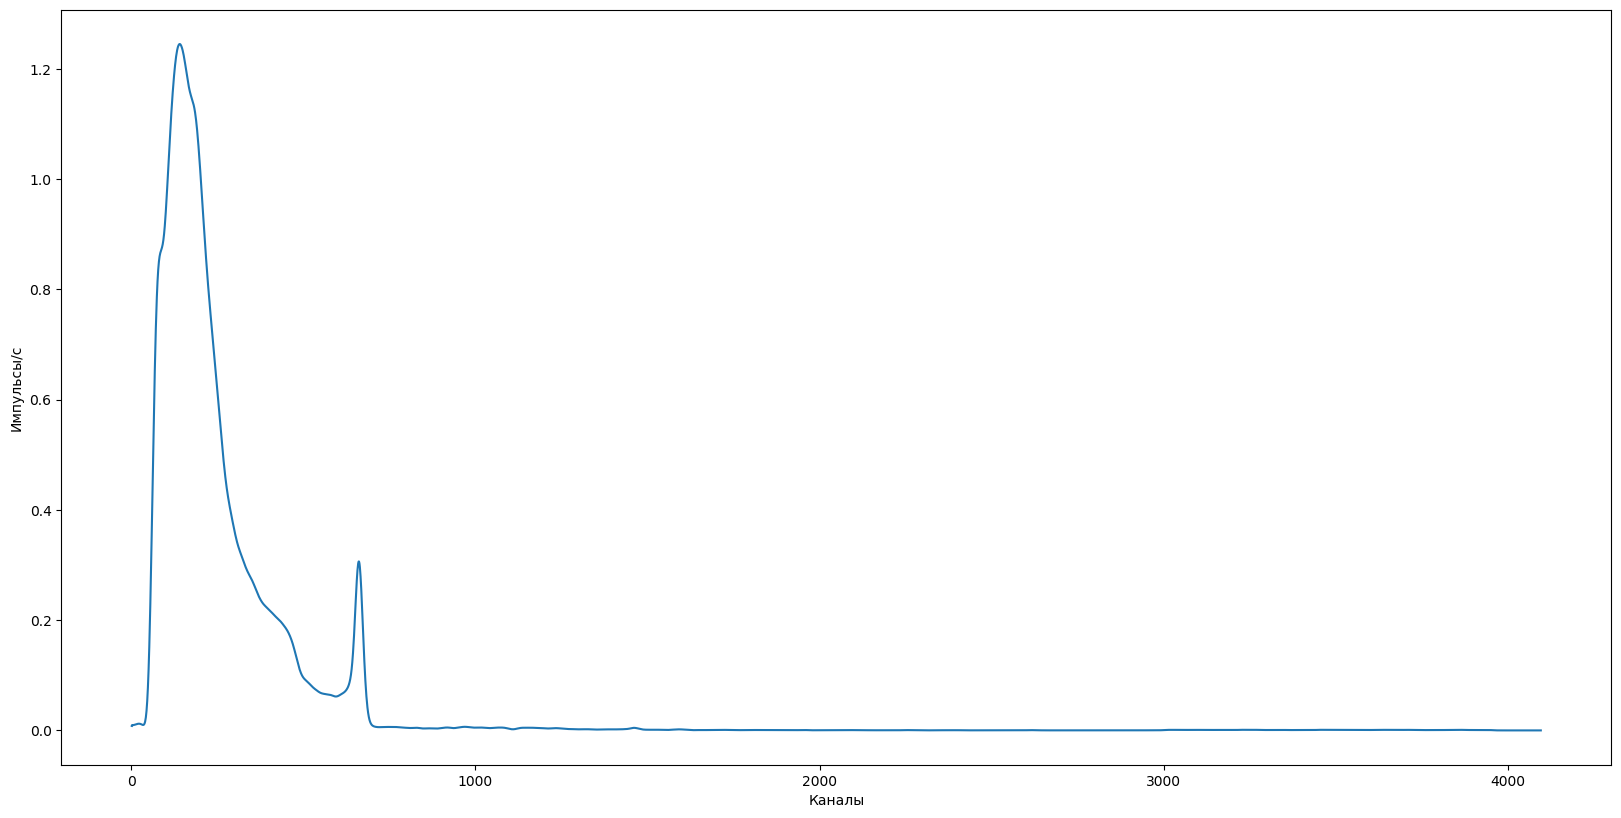

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline        
import numpy as np
# выводит график в редакторе кода
chanel_tmp=[]
for i in range (4096):
    chanel_tmp.append(chanel[0][i])
    
fig=plt.figure(figsize=(20,10), dpi=100)
plt.plot(np.arange(1,4097,1), chanel_tmp)
plt.xlabel('Каналы')
plt.ylabel('Импульсы/с')
fig.savefig('integr_out', fmt='png')

In [11]:
# поиск констант и подсчет интеграла

from scipy.optimize import minimize
from scipy import integrate
import numpy as np
import math

h=1 # высота от детектора до нижней плоскости
l=0.1 # толщина слоя грунта над источником
chanel_out=[]
mistake=[]
mistake_last=[]
x=np.arange(0,0.56,0.05)

f_tmpout_alpha=open('tmp_alpha.txt', 'w')
f_tmpout_beta=open('tmp_beta.txt', 'w')
f_tmplast_alpha=open('tmplast_alpha.txt', 'w')
f_tmplast_beta=open('tmplast_beta.txt', 'w')

#f_out=open('koeff.txt', 'w')
#f_nevyazka=open('nevyazka.txt','w')
#bnds=((0, None),(0,None))

interpol=[]
extrapol=[]

for p in range (4096):
    
    def f(x,alpha,beta):
         return alpha*h*np.exp(((-1)*beta*l*(h**2+x**2)**0.5)/h)/(h**2+x**2)**1.5
        
    def delta(alpha, beta):
        d=0
        for i in range(12):
            d=d+(f(x[i],alpha,beta)-chanel[i][p])**2 
        return d
    
    res=minimize(lambda x: delta(*x), [1,1], bounds=bnds)
    a=res.x[0]
    b=res.x[1]
    
    mistake.append((res.fun)**0.5)
    
    #f_out.write(str(p+1) + '   alpha=' + str("%.4f" % a) + ' beta=' + str("%.4f" % b) + ',    ')
    #f_nevyazka.write(str(p+1) + '  '+ str("%.6f" % res.fun))

    if a<0:
        a=0
    
    f_tmpout_alpha.write(str("%.6f" % a) + '\n')
    f_tmpout_beta.write(str("%.6f" % b) + '\n')
    
     # получил альфа и бета для интерполирующей функции на всем интервале

    def g(x):
        return 2*np.pi*x*a*h*np.exp(((-1)*b*l*(h**2+x**2)**0.5)/h)/(h**2+x**2)**1.5
    
    carpet=integrate.quad(g,0,0.55)
    interpol.append(carpet[0])
    
    # проинтегрировал интерполирующую функцию на интервале (0,0.55)
        
    def f_last(x, alpha,beta):
         return alpha*h*np.exp(((-1)*beta*l*(h**2+x**2)**0.5)/h)/(h**2+x**2)**1.5

    def delta_last(alpha,beta):
        d=0
        for i in range(10,12):
            d=d+(f_last(x[i],alpha,beta)-chanel[i][p])**2 
        return d

    res_last=minimize(lambda x: delta_last(*x), [1,1])
    a=res_last.x[0]
    b=res_last.x[1]
       
    #f_out.write('на последнем интервале alpha='+ str("%.4f" % a) + ', beta= ' + str("%.4f" % b) + '\n')
    #f_nevyazka.write('  ' + str("%.6f" % res_last.fun) + '\n')
    
    if a<0:
        a=0    
    
    mistake_last.append((res_last.fun)**0.5)
    
    f_tmplast_alpha.write(str("%.6f" % a) + '\n')
    f_tmplast_beta.write(str("%.6f" % b) + '\n')
    
    # получил альфа и бета для последнего интервала
    
    def g_last(x):
        return 2*np.pi*x*a*h*np.exp(((-1)*b*l*(h**2+x**2)**0.5)/h)/(h**2+x**2)**1.5
    
    carpet_last=integrate.quad(g_last,0.55, np.inf)
    
    # проинтегрировал интерполирующую функцию с коэффициентами из последнего интервала по бесконечности
    
    extrapol.append(carpet_last[0])
    chanel_out.append(carpet[0]+carpet_last[0])
    
f_integr=open('integr.txt', 'w')
f_integr.write('кэВ  ' + '  имп*м^2/с' + '\n')
f_interpol=open('internal.txt','w')
f_extrapol=open('external.txt','w')

f_mistake=open('mistake.txt', 'w')
f_mistake_last=open('mistake_last.txt', 'w')

for i in range(4096):
    f_integr.write(str("%.6f" % chanel_out[i]) + '\n')
    f_interpol.write(str("%.6f" % interpol[i]) + '\n')
    f_extrapol.write(str("%.6f" % extrapol[i]) + '\n')
    f_mistake.write(str("%.6f" % mistake[i]) + '\n')
    f_mistake_last.write(str("%.6f" % mistake_last[i]) + '\n')

f_tmplast_alpha.close()    
f_tmplast_beta.close()
f_integr.close()
f_tmpout_alpha.close()
f_tmpout_beta.close()
f_mistake.close()
f_mistake_last.close()
#f_out.close()
#f_nevyazka.close()
f_interpol.close()
f_extrapol.close() 